In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from itertools import groupby

# Generate Data

In [2]:
from genICD import *

In [3]:
M_dgp = 100  # number of documents
K_trunc = 100 # truncation level for number of topics 
gamma = 3  # some approximations used in the inference below rely on gamma not being large (cf ICD appendix)
alpha = 3
Nvocabulary = 50
eta = np.ones(Nvocabulary)/Nvocabulary
supervised = True
mu_a = 0
sigma_a = 1
sigma_y = 1

phi_dgp, beta, pi_dgp, b_dgp, n_dgp, theta, z_dgp, w_dgp, y_dgp, a_dgp = \
    FTM_synthetic_data(M_dgp, K_trunc, Nvocabulary, gamma, alpha, eta, supervised, mu_a, sigma_a, sigma_y)
n_dgp

array([ 2,  3,  1, 17,  8,  9, 21, 13,  9, 10,  2,  8,  9, 28, 15,  9,  5,
       12,  9, 18, 20, 11,  4, 15, 17,  4,  8, 10, 12,  2, 16,  5,  4, 14,
       14,  6, 20, 17, 11,  5,  6,  2, 11,  6,  5,  9, 11, 10, 12,  6,  9,
        7, 14, 12, 22,  8,  7,  2,  9,  9,  2, 13, 18, 14,  6,  2,  9,  6,
       10, 11, 19,  4, 14, 13,  9,  5,  6, 13,  3, 13,  7, 16,  7,  6, 13,
        8,  2, 16,  8,  6,  6, 15,  8,  6, 13, 15, 10, 12, 17, 12])

-0.0975585132748


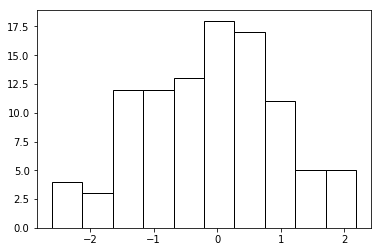

In [4]:
print y_dgp.mean()
plt.hist(y_dgp, edgecolor='k', color='white');

In [5]:
n_per_mk_dgp = get_n_per_mk(z_dgp,K_trunc)
print n_per_mk_dgp.shape
# check correctness by summing counts over all topics
(n_per_mk_dgp.sum(axis=1)-n_dgp).sum()

(100L, 100L)


0.0

In [6]:
n_per_ik_dgp = get_n_per_ik(z_dgp, w_dgp, K_trunc, Nvocabulary)
print n_per_ik_dgp.shape
n_per_ik_dgp.sum() - n_dgp.sum() # should be 0

(50L, 100L)


0.0

In [7]:
# not all words in vocabulary will have been used
words_used = [w for w_m in w_dgp for w in w_m]
len(set(words_used)), (n_per_ik_dgp.sum(axis=1)==0).sum()

(34, 16)

(0, 17L)

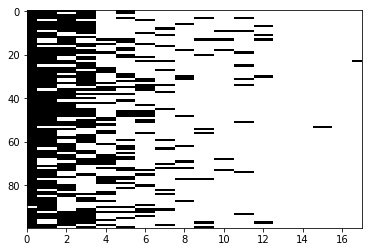

In [8]:
Kmax = n_per_mk_dgp[:,~np.all(n_per_mk_dgp==0, axis=0)].shape[1]

plt.imshow(b_dgp, cmap='Greys', aspect='auto');
plt.xlim(0,Kmax)

# Inference

In [9]:
from inferenceICD import *

In [10]:
# initialize with data generating parameters
iters = 50
samples,logs = sICD_collapsed_gibbs(iters, w_dgp, Nvocabulary, alpha, gamma, eta, z_dgp, phi_dgp, pi_dgp, b_dgp, supervised=True, y=y_dgp, a0=a_dgp, 
                         mu_a=mu_a, sigma_a=sigma_a, sigma_y=sigma_y)

inferenceICD.py:106: RuntimeWarning: divide by zero encountered in log
  return np.log(phi>0) + logp
inferenceICD.py:176: RuntimeWarning: invalid value encountered in less
  mask = np.log(np.random.uniform(size=K_plus)) < logr


In [11]:
# train-test split
percentage_test = 0.5
testindices = np.random.choice(range(M_dgp), size=int(M_dgp*percentage_test), replace=False)

w_dict = {'all':w_dgp, 'test':[w_dgp[idx] for idx in testindices], 'train':np.delete(w_dgp,testindices, axis=0)}
b_dict = {'all':b_dgp, 'test':b_dgp[testindices,:], 'train':np.delete(b_dgp,testindices, axis=0)}
if supervised:
    y_dict = {'all':y_dgp, 'test':y_dgp[testindices], 'train':np.delete(y_dgp,testindices, axis=0)}

In [12]:
#%%time
# settings
iters = 100
Npoints = 1000  # number of points for approximating CDF for slice sampler
iters_MH = 100
sigma_proposal = 1  # for MH
supervised = True

# train
dataset = 'train' #'train', 'test', 'all'
w = w_dict[dataset]
M = len(w)
if supervised:
    y = y_dict[dataset]

# initialization
K = Kmax
z = [np.random.choice(range(K),size=len(w_m)) for w_m in w]  # list(z_dgp)
phi = np.random.gamma(gamma,1, size=K)
pi = IBP_stick_breaking(alpha,M,K)
b = np.random.binomial(n=1, p=pi, size=(M,K))
a = np.random.normal(mu_a, sigma_a, size=K)

samples_train,logs_train = sICD_collapsed_gibbs(iters, w, Nvocabulary, alpha, gamma, eta, z, phi, pi, b, supervised=supervised, y=y, a0=a, 
                         mu_a=mu_a, sigma_a=sigma_a, sigma_y=sigma_y, iters_MH=iters_MH, sigma_proposal=sigma_proposal)

In [13]:
# test
dataset = 'test' #'train', 'test', 'all'
w = w_dict[dataset]
M = len(w)
if supervised:
    y = y_dict[dataset]

K = Kmax
z = [np.random.choice(range(K),size=len(w_m)) for w_m in w]  # list(z_dgp)
phi = np.random.gamma(gamma,1, size=K)
pi = IBP_stick_breaking(alpha,M,K)
b = np.random.binomial(n=1, p=pi, size=(M,K))

samples_test,logs_test = sICD_collapsed_gibbs(iters, w, Nvocabulary, alpha, gamma, eta, z, phi, pi, b, supervised=False, 
                                              iters_MH=iters_MH, sigma_proposal=sigma_proposal)

In [14]:
settings = 'iters='+str(iters)+',M='+str(M_dgp)+',Nvocab='+str(Nvocabulary)+',gamma='+str(gamma)+',alpha='+str(alpha)+',supervised='+str(supervised)
if supervised:
    settings += ',mu_a='+str(mu_a)+',sigma_a='+str(sigma_a)+',sigma_y='+str(sigma_y)
    
fileending = settings+'_9'

In [15]:
samples = {'test':samples_test, 'train':samples_train}
logs = {'test':logs_test, 'train':logs_train}

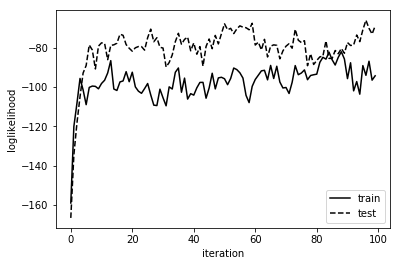

In [16]:
plt.plot(logs_train['loglikelihood'], 'k', label='train')
plt.plot(logs_test['loglikelihood'], '--k', label='test')
#plt.plot(loglikelihoods, '--k')
plt.xlabel('iteration')
plt.ylabel('loglikelihood');
plt.legend();
plt.savefig('figures/loglikelihood_'+fileending+'.png', bbox_inches='tight')

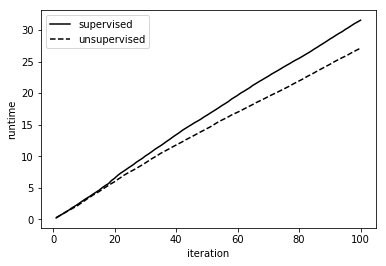

In [17]:
plt.plot(logs_train['iteration'], logs_train['runtime'], 'k', label='supervised')
plt.plot(logs_test['iteration'], logs_test['runtime'], '--k', label='unsupervised')
plt.ylabel('runtime')
plt.xlabel('iteration');
plt.legend();
plt.savefig('figures/runtime_'+fileending+'.png', bbox_inches='tight')

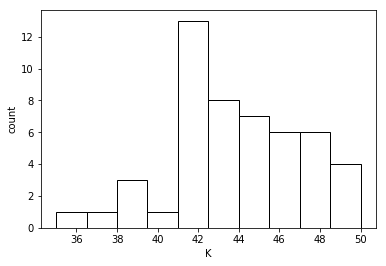

In [18]:
dataset = 'train'

K_mode = np.bincount(samples[dataset]['K'][iters//2:]).argmax()
#print K_mode, np.mean(samples[dataset]['K'][iters/2:])

plt.hist(samples[dataset]['K'][iters//2:], edgecolor='k', color='white');
plt.xlabel('K')
plt.ylabel('count');
plt.savefig('figures/histK_'+fileending+'_'+dataset+'.png', bbox_inches='tight')

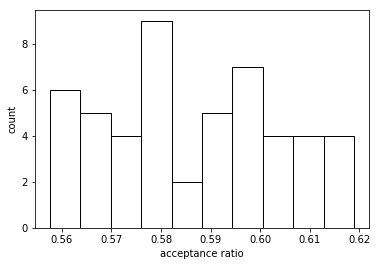

In [19]:
#print np.mean(logs[dataset]['acceptance_ratio'][iters/2:])
plt.hist(logs[dataset]['acceptance_ratio'][iters//2:], edgecolor='k', color='white');
plt.xlabel('acceptance ratio')
plt.ylabel('count')
plt.savefig('figures/histAcceptanceRatio_'+fileending+'_'+dataset+'.png', bbox_inches='tight')

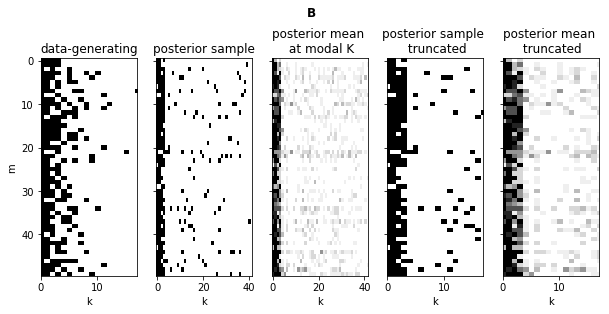

In [20]:
fig,[ax1,ax2,ax3,ax4,ax5] = plt.subplots(1,5, sharey=True, figsize=[10,4])
fig.suptitle(r'$\mathbf{B}$',y=1.06)

ax1.imshow(b_dict[dataset], cmap='Greys', aspect='auto');
ax1.set_xlim(0,Kmax)
ax1.set_xlabel('k')
ax1.set_ylabel('m')
ax1.set_title(r'data-generating')

b_K_mode = [b for b in samples[dataset]['b'][iters//2:] if b.shape[1]==K_mode]
ax2.imshow(b_K_mode[-1], cmap='Greys', aspect='auto');
ax2.set_xlabel('k')
ax2.set_title('posterior sample')

ax3.imshow(np.mean(b_K_mode,axis=0), cmap='Greys', aspect='auto');
ax3.set_xlabel('k');
ax3.set_title('posterior mean \n at modal K');

ax4.imshow(b_K_mode[-1], cmap='Greys', aspect='auto');
ax4.set_xlim(0,Kmax)
ax4.set_xlabel('k')
ax4.set_title('posterior sample \n truncated')

ax5.imshow(np.mean(b_K_mode,axis=0), cmap='Greys', aspect='auto');
ax5.set_xlim(0,Kmax)
ax5.set_xlabel('k');
ax5.set_title('posterior mean \n truncated');

plt.savefig('figures/b_'+fileending+'_'+dataset+'.png', bbox_inches='tight')

In [21]:
def R2(yhat,y):
    # <0 means yhat fits worse than sample  mean y.mean()
    return 1 - np.sum((yhat-y)**2) / np.sum((y-y.mean())**2)

In [22]:
# sICD
# train
y_train_sICD = samples['train']['y_hat'][iters//2:]
# test
K2a_dict_sICD = {K: np.mean(list(a),axis=0) for K,a in groupby(samples['train']['a'][iters//2:], key=lambda a: len(a))}
y_test_sICD = [(get_n_per_mk(z,K)/get_n_per_mk(z,K).sum(axis=1)[:,np.newaxis]).dot(K2a_dict_sICD[K]) for z,K in zip(samples['test']['z'],samples['test']['K']) if K in K2a_dict_sICD]

# 2-step
# train
y_train_2step, a_2step = [],[]
for z,K in zip(samples['train']['z'],samples['train']['K']):
    n_per_mk = get_n_per_mk(z,K)
    X = np.nan_to_num(n_per_mk / n_per_mk.sum(axis=1)[:,np.newaxis])
    a_postvar = np.linalg.pinv(X.T.dot(X)+np.eye(K)*sigma_a**2)
    a_postmean = a_postvar.dot(X.T).dot(y_dict['train'])
    a = np.random.multivariate_normal(a_postmean, a_postvar)
    y_train_2step.append(X.dot(a))
    a_2step.append(a)
# test    
K2a_dict_2step = {K: np.mean(list(a),axis=0) for K,a in groupby(a_2step[iters//2:], key=lambda a: len(a))}
y_test_2step = [get_n_per_mk(z,K).dot(K2a_dict_2step[K]) for z,K in zip(samples['test']['z'],samples['test']['K']) if K in K2a_dict_2step]

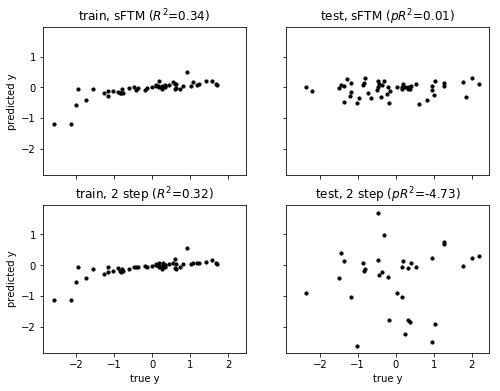

In [23]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=[8,6])
axes_col1, axes_col2 = axes.T

for ax,y,method in zip(axes_col1,[y_train_sICD,y_train_2step],['sFTM','2 step']):
    R2_ = R2(np.mean(y,axis=0),y_dict['train'])
    #MSE = np.mean((np.mean(y,axis=0)-y_dict['train'])**2)
    ax.set_title('train, '+method+r' ($R^2$='+str(round(R2_,2))+')')
    ax.scatter(y_dict['train'],np.mean(y,axis=0), color='k', s=10)
    #ax.hist(np.mean(y,axis=0), normed=True, alpha=0.5, label='predicted response');
    #ax.hist(y_dict['train'], normed=True, alpha=0.5, label='true response');
    ax.set_ylabel('predicted y')
    ax.set_ylim(ax.get_xlim())
    
for ax,y,method in zip(axes_col2,[y_test_sICD,y_test_2step],['sFTM','2 step']):
    pR2 = R2(np.mean(y,axis=0),y_dict['test'])
    #MSE = np.mean((np.mean(y,axis=0)-y_dict['test'])**2)
    ax.set_title('test, '+method+r' ($pR^2$='+str(round(pR2,2))+')')
    ax.scatter(y_dict['test'],np.mean(y,axis=0), color='k', s=10)
    #ax.hist(np.mean(y,axis=0), normed=True, alpha=0.5, label='predicted response');
    #ax.hist(y_dict['test'], normed=True, alpha=0.5, label='true response');

axes_col1[-1].set_xlabel('true y')
axes_col2[-1].set_xlabel('true y');

plt.savefig('figures/Y_predictedVStrue'+fileending+'.png', bbox_inches='tight')